# RayEmb Inference Notebook
This notebook demonstrates how to use the RayEmb model for inference.
We will use the RealDeepFluoro dataset for this demonstration. But you can use any other data that matches the inference function signature.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using cache found in /home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using MLP layer as FFN


### Set up dataset and model

In [1]:
import sys
sys.path.append('../')
import os
import json
import time

import torch
import matplotlib.pyplot as plt
import numpy as np
import gc
import nibabel as nib

from diffdrr.pose import convert
from rayemb.models import RayEmb, FixedLandmark
from rayemb.dataset import SyntheticCTPelvic1KDataset, RealDeepFluoroDataset
from rayemb.utils import setup_logger, cosine_similarity, find_batch_peak_coordinates_maxval

logger = setup_logger(__name__)

# Model parameters
checkpoint_path = '../checkpoints/rayemb-ctpelvic1k.ckpt'
device = 'cuda'
image_size = 224
emb_dim = 32

# Dataset parameters
specimen_id = 'specimen_2'
num_samples = 300
h5_dir = '../data/ipcai_2020_full_res_data.h5'
template_dir = '../data/deepfluoro_templates'

model = RayEmb.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    map_location=torch.device(device),
    similarity_fn=cosine_similarity,
    image_size=image_size,
    emb_dim=emb_dim,
)

model.eval()

dataset = RealDeepFluoroDataset(
    specimen_id=specimen_id,
    num_samples=num_samples,
    h5_dir=h5_dir,
    sampling_distance=1,
    template_dir=template_dir,
    sample_only_visible=True,
    image_size=image_size,
)

Using cache found in /home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/pragyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using MLP layer as FFN


### Run through the model

In [2]:
data_idx = 0
data = dataset[data_idx]

img_target = data["img"][0].to(device).double()[None, None, ...]
# specimen = dataset.specimens[data["specimen_id"]]
gt_pose = data["diffdrr_pose"]
gt_pose = convert(gt_pose, parameterization='matrix').to(device)
gt_vol_landmarks = data["gt_vol_landmarks"].unsqueeze(0).to(device)

for key, value in data.items():
    if isinstance(value, torch.Tensor):
        data[key] = value.to(device).float()

specimen_id = data["specimen_id"]
img_id = data["img_id"]
imgs = data["img"]
templates = data["templates"]
projection_matrices = data["projection_matrices"]
sampled_points = data["sampled_points"][:, :-1]
img_sensor_size = data["img_sensor_size"][0].item()
source_to_detector_distance = data["source_to_detector_distance"]
specimen_id = data["specimen_id"]
vol_landmark = data["gt_vol_landmarks"].cpu().numpy()
proj_landmark = data["gt_proj_landmarks"].cpu().numpy()
query_projection_matrix = data["query_projection_matrix"]
K = data["K"].cpu().numpy()
diffdrr_pose = data["diffdrr_pose"]
gt_extrinsic = data["extrinsic"]
gt_proj_point = data["proj_point_img"].cpu().numpy()
pixel_size = data["pixel_size"].item()
flip_xz = data["flip_xz"].to(device)
translate = data["translate"].to(device)

sims = model.inference(imgs, templates, sampled_points, projection_matrices, return_features=False)
proj_point, max_vals = find_batch_peak_coordinates_maxval(sims)
proj_points_np = proj_point.cpu().numpy()


### Visualize the results

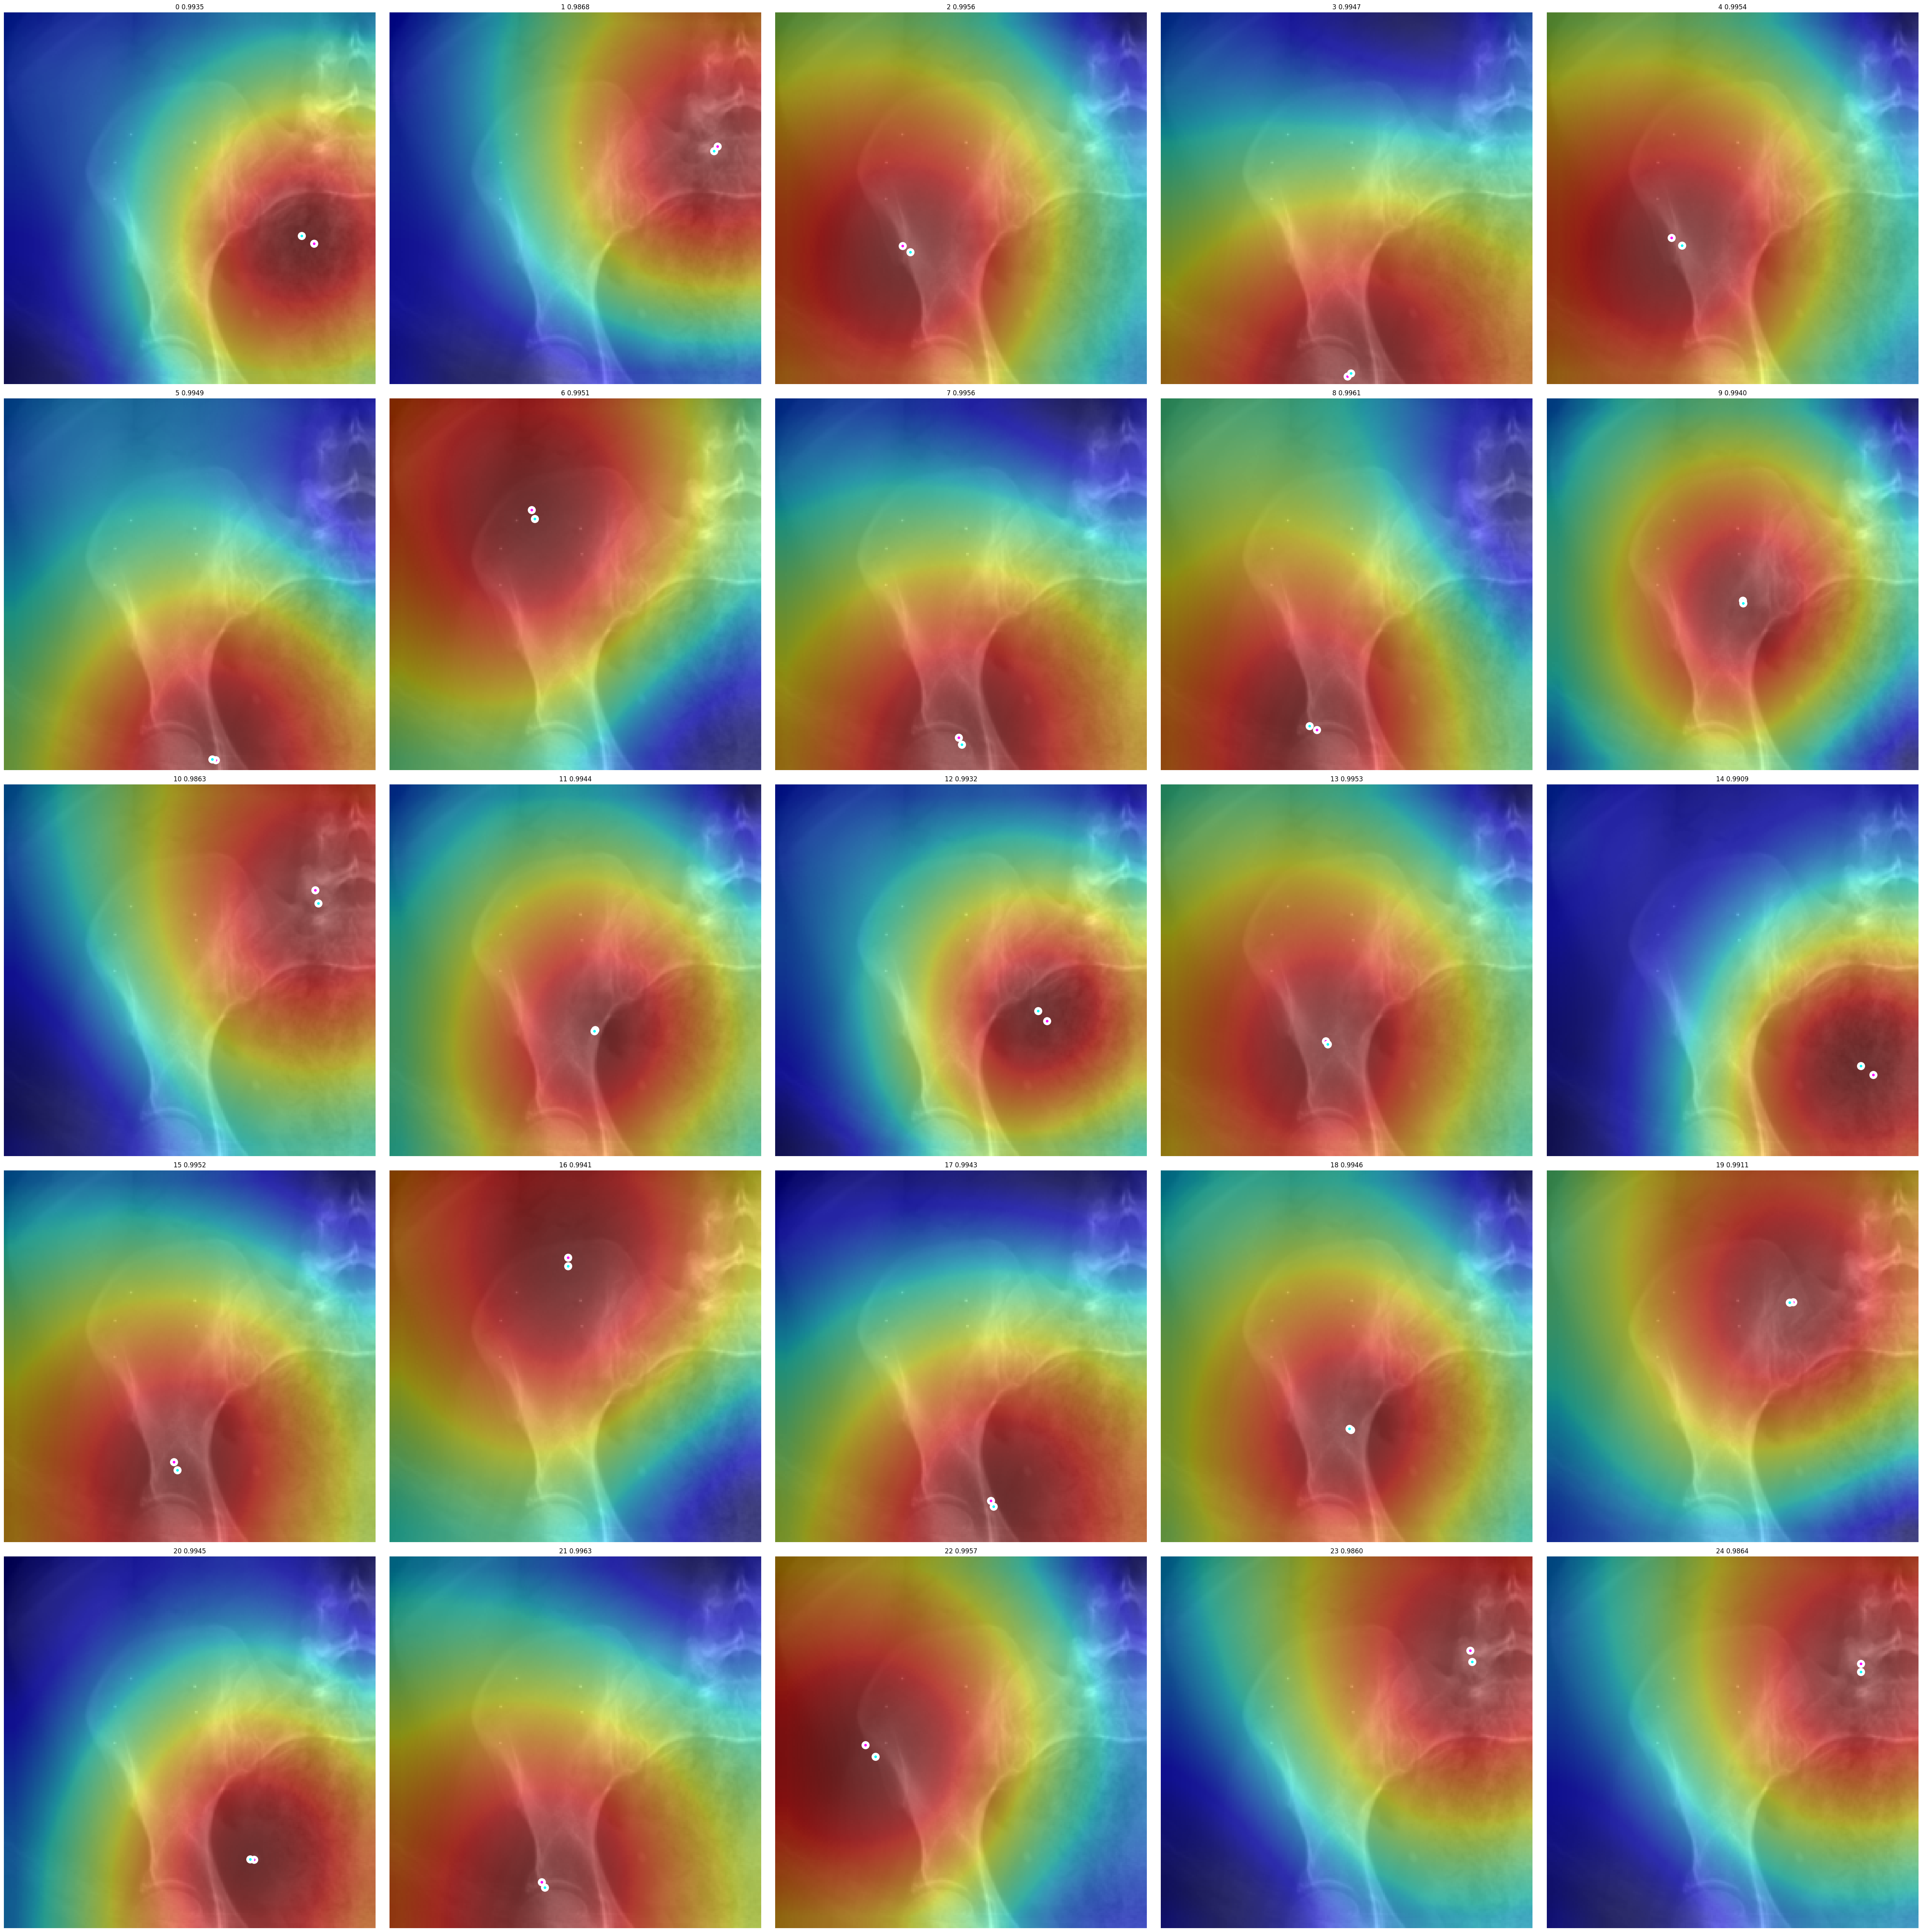

In [3]:
error = np.linalg.norm(gt_proj_point - proj_points_np, axis=-1)

fig = plt.figure(figsize=(50, 50))
num_cols = 5
num_rows = 5
axes = fig.subplots(num_rows, num_cols)
axes = axes.flatten()
sims_np = sims.cpu().numpy()
img_np = imgs.cpu().numpy()[0]
for i in range(num_rows * num_cols):
    axes[i].imshow(img_np, cmap="gray")
    axes[i].imshow(sims_np[i], cmap="jet", alpha=0.5)
    axes[i].scatter(gt_proj_point[i, 0], gt_proj_point[i, 1], s=100,  # s is the size of the marker
                    facecolors='magenta', edgecolors='w', linewidths=5,  # no fill, blue edge, width of 2
                    label='GT')

    # Plotting the projected points as green circles
    axes[i].scatter(proj_points_np[i, 0], proj_points_np[i, 1], s=100,
                    facecolors='cyan', edgecolors='w', linewidths=5,  # no fill, green edge, width of 2
                    label='Projected')
    axes[i].set_title(f"{i} {max_vals[i]:.4f}")
    axes[i].axis("off")
fig.tight_layout()
plt.show()

### Save the embeddings for use in demo application


In [8]:
img_embeddings, template_embeddings = model.forward_features(imgs.unsqueeze(0), templates.unsqueeze(0))
np.save("../results/img_embeddings.npy", img_embeddings.cpu().detach().numpy())
np.save("../results/template_embeddings.npy", template_embeddings.cpu().detach().numpy())